In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


In [3]:
# 1) Load data ---------------------------------------------------------------
df = pd.read_csv("polio_2020.csv")  

In [4]:
df.head()

,Age,Gender,SES,Vaccination_Status,Unnamed: 4,Paralysis,Fever,Muscle_Weakness,OPV_Doses,IPV_Doses,Caregiver_Age,Caregiver_Education,Campaign_Recent
0,38,Male,Low,Fully Vaccinated,NaN,No,No,No,4,0,21,Secondary,Yes
1,51,Male,Middle,Partially Vaccinated,NaN,No,No,No,2,2,27,Tertiary,No
2,28,Female,Middle,Fully Vaccinated,NaN,No,No,No,1,0,29,Secondary,No
3,14,Male,Low,Partially Vaccinated,NaN,No,No,Yes,0,2,35,Secondary,No
4,42,Male,Low,Partially Vaccinated,NaN,No,No,No,4,1,32,Primary,No


In [5]:
# 2) Detect the target column (polio vaccination status) ---------------------
possible_targets = [
    "polio_vaccination", "polio_vaccinated", "polio_status", "polio",
    "polio_immunization", "polio_immunisation", "polio_vaccine_status",
    "received_polio_vaccine", "vaccinated_polio"
]
lower_map = {c.lower(): c for c in df.columns}
target_col = None
for t in possible_targets:
    if t in lower_map:
        target_col = lower_map[t]
        break

if target_col is None:
    for c in df.columns:
        lc = c.lower()
        if ("vaccinated" in lc or "immunized" in lc or "immunised" in lc) and "polio" in " ".join(lower_map.keys()):
            target_col = c
            break


In [6]:
# last resort: pick a low-cardinality binary-looking column
if target_col is None:
    candidates = []
    for c in df.columns:
        uniq = df[c].dropna().unique()
        if len(uniq) <= 5:
            vals = [str(x).strip().lower() for x in uniq]
            if any(v in ("yes","no","y","n","1","0","true","false") for v in vals):
                candidates.append(c)
    target_col = candidates[0] if candidates else df.columns[-1]

print(f"Detected target column: {target_col}")


Detected target column: Paralysis


In [18]:
# 3) Basic cleaning ----------------------------------------------------------
drop_like = [
    "patient_id", "id", "national_id", "phone", "name", "address",
    "gps", "latitude","unnamed: 4", "longitude", "notes", "comments"
]
to_drop = [lower_map[c] for c in drop_like if c in lower_map]
df = df.drop(columns=to_drop, errors="ignore")

In [19]:
# Remove rows with missing target
df = df.dropna(subset=[target_col])


In [20]:
# Normalize target to Yes/No
def to_yes_no(x):
    s = str(x).strip().lower()
    if s in ("yes","y","1","true","vaccinated","completed","complete","received","done"):
        return "Yes"
    if s in ("no","n","0","false","not vaccinated","none","incomplete","pending"):
        return "No"
    # If unclear, keep as-is; we’ll drop unknowns
    return np.nan

df["target_binary"] = df[target_col].apply(to_yes_no)
df = df.dropna(subset=["target_binary"])

In [21]:
# Display the first few rows
print("🔹 First 5 rows of the dataset:")
print(df.head())

🔹 First 5 rows of the dataset:
   Age  Gender     SES    Vaccination_Status Paralysis Fever Muscle_Weakness  \
0   38    Male     Low      Fully Vaccinated        No    No              No   
1   51    Male  Middle  Partially Vaccinated        No    No              No   
2   28  Female  Middle      Fully Vaccinated        No    No              No   
3   14    Male     Low  Partially Vaccinated        No    No             Yes   
4   42    Male     Low  Partially Vaccinated        No    No              No   

   OPV_Doses  IPV_Doses  Caregiver_Age Caregiver_Education Campaign_Recent  \
0          4          0             21           Secondary             Yes   
1          2          2             27            Tertiary              No   
2          1          0             29           Secondary              No   
3          0          2             35           Secondary              No   
4          4          1             32             Primary              No   

  target_binary  
0

In [22]:
# Summary statistics for numerical columns
print("\n🔹 Summary statistics for numeric data:")
print(df.describe())



🔹 Summary statistics for numeric data:
                Age     OPV_Doses     IPV_Doses  Caregiver_Age
count  43500.000000  43500.000000  43500.000000   43500.000000
mean      29.480437      2.503356      0.994483      27.560690
std       17.292860      1.704392      0.816515       5.869334
min        0.000000      0.000000      0.000000      16.000000
25%       15.000000      1.000000      0.000000      23.000000
50%       29.000000      2.000000      1.000000      28.000000
75%       45.000000      4.000000      2.000000      32.000000
max       59.000000      5.000000      2.000000      50.000000


In [23]:
# Summary statistics for categorical columns
print("\n🔹 Summary statistics for categorical data:")
print(df.describe(include=['object']))


🔹 Summary statistics for categorical data:
        Gender    SES Vaccination_Status Paralysis  Fever Muscle_Weakness  \
count    43500  43500              43500     43500  43500           43500   
unique       2      3                  3         2      2               2   
top     Female    Low   Fully Vaccinated        No     No              No   
freq     21808  21664              21817     40148  38529           39370   

       Caregiver_Education Campaign_Recent target_binary  
count                32693           43500         43500  
unique                   3               2             2  
top              Secondary              No            No  
freq                 10977           26191         40148  



🔹 Correlation matrix (numerical variables):
                    Age  Unnamed: 4  OPV_Doses  IPV_Doses  Caregiver_Age
Age            1.000000         NaN   0.000113   0.001529      -0.001680
Unnamed: 4          NaN         NaN        NaN        NaN            NaN
OPV_Doses      0.000113         NaN   1.000000  -0.004381       0.003245
IPV_Doses      0.001529         NaN  -0.004381   1.000000       0.007596
Caregiver_Age -0.001680         NaN   0.003245   0.007596       1.000000


In [24]:
# 4) EDA (prints + a few plots) ---------------------------------------------
print("\n=== SHAPE ===")
print(df.shape)

print("\n=== MISSING VALUES (top 15) ===")
print(df.isnull().sum().sort_values(ascending=False).head(15))

print("\n=== TARGET DISTRIBUTION ===")
print(df["target_binary"].value_counts(dropna=False))



=== SHAPE ===
(43500, 13)

=== MISSING VALUES (top 15) ===
Caregiver_Education    10807
Age                        0
Gender                     0
SES                        0
Vaccination_Status         0
Paralysis                  0
Fever                      0
Muscle_Weakness            0
OPV_Doses                  0
IPV_Doses                  0
Caregiver_Age              0
Campaign_Recent            0
target_binary              0
dtype: int64

=== TARGET DISTRIBUTION ===
target_binary
No     40148
Yes     3352
Name: count, dtype: int64


In [25]:
# Correlation matrix
print("\n🔹 Correlation matrix (numerical variables):")
print(df.corr(numeric_only=True))


🔹 Correlation matrix (numerical variables):
                    Age  OPV_Doses  IPV_Doses  Caregiver_Age
Age            1.000000   0.000113   0.001529      -0.001680
OPV_Doses      0.000113   1.000000  -0.004381       0.003245
IPV_Doses      0.001529  -0.004381   1.000000       0.007596
Caregiver_Age -0.001680   0.003245   0.007596       1.000000


In [26]:
# Check for missing values
print("\n🔹 Missing values per column:")
print(df.isnull().sum())


🔹 Missing values per column:
Age                        0
Gender                     0
SES                        0
Vaccination_Status         0
Paralysis                  0
Fever                      0
Muscle_Weakness            0
OPV_Doses                  0
IPV_Doses                  0
Caregiver_Age              0
Caregiver_Education    10807
Campaign_Recent            0
target_binary              0
dtype: int64


In [27]:
df.isnull().sum()

Age                        0
Gender                     0
SES                        0
Vaccination_Status         0
Paralysis                  0
Fever                      0
Muscle_Weakness            0
OPV_Doses                  0
IPV_Doses                  0
Caregiver_Age              0
Caregiver_Education    10807
Campaign_Recent            0
target_binary              0
dtype: int64

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3480\1146850441.py:4: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\ADMIN\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


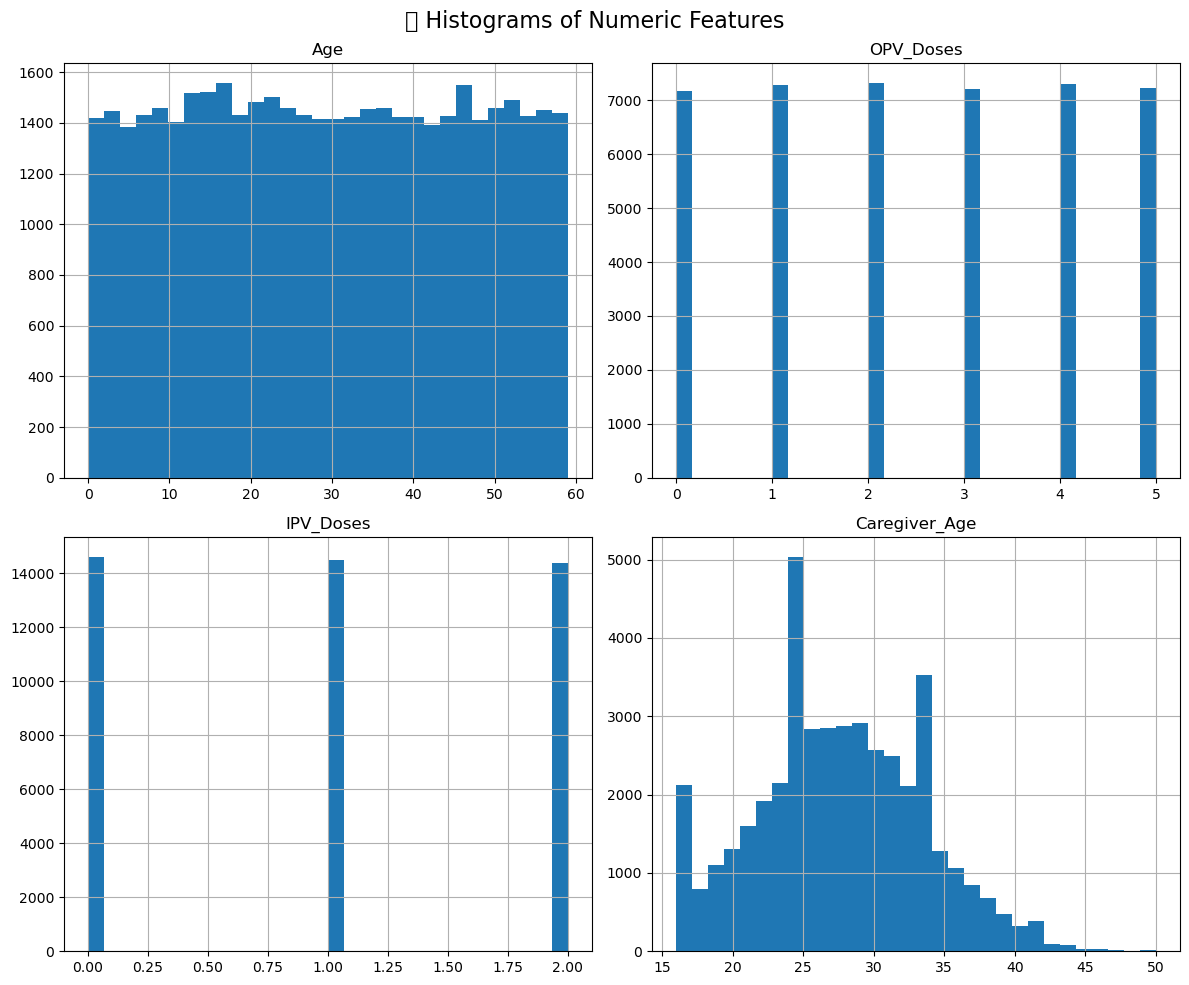

In [28]:
# Plot: Histogram of numeric columns
df.hist(figsize=(12, 10), bins=30)
plt.suptitle('📊 Histograms of Numeric Features', fontsize=16)
plt.tight_layout()
plt.show()

C:\Users\ADMIN\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


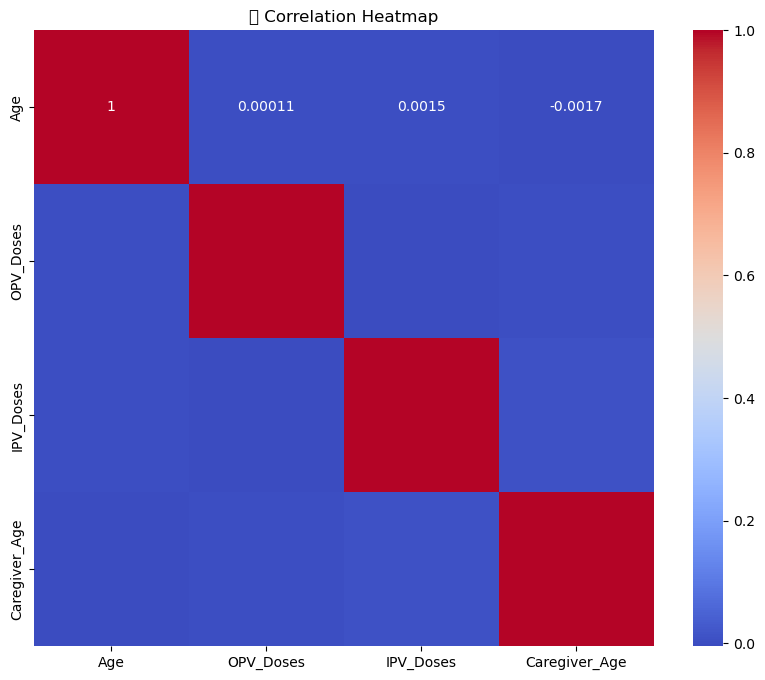

In [32]:
#Plot: Heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('📈 Correlation Heatmap')
plt.show()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3480\3149100879.py:12: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\ADMIN\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


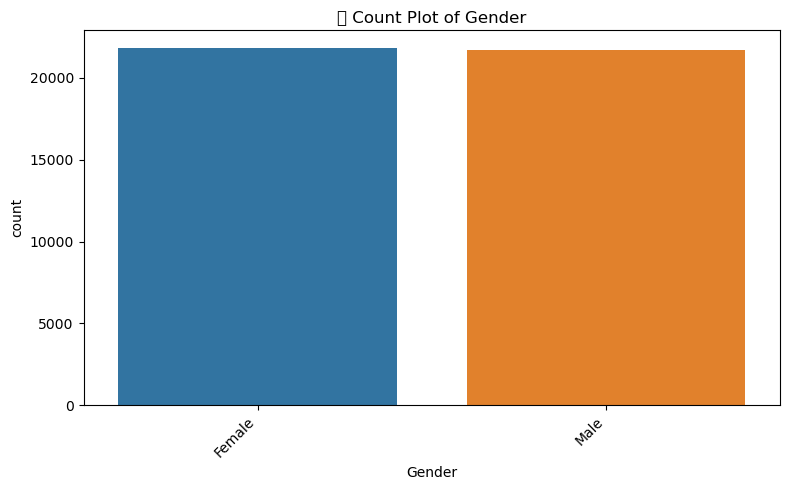

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3480\3149100879.py:12: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\ADMIN\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


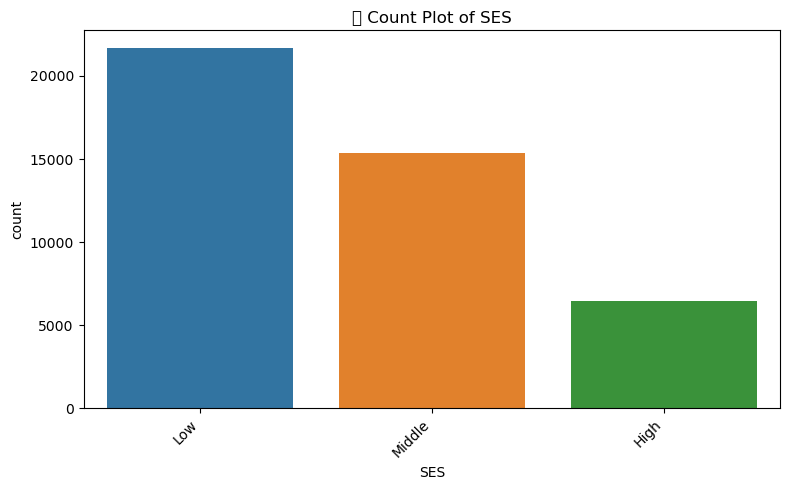

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3480\3149100879.py:12: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\ADMIN\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


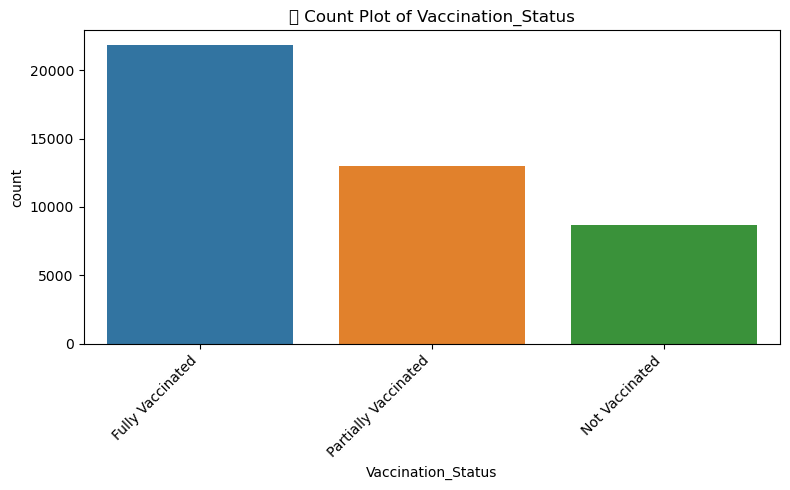

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3480\3149100879.py:12: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\ADMIN\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


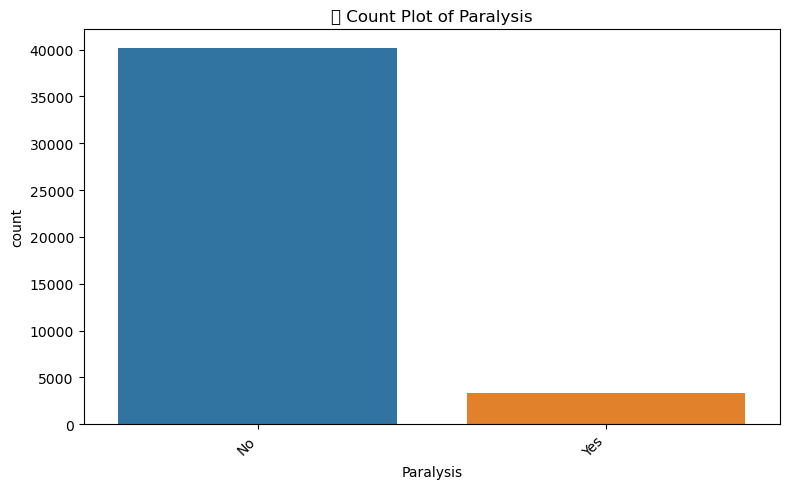

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3480\3149100879.py:12: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\ADMIN\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


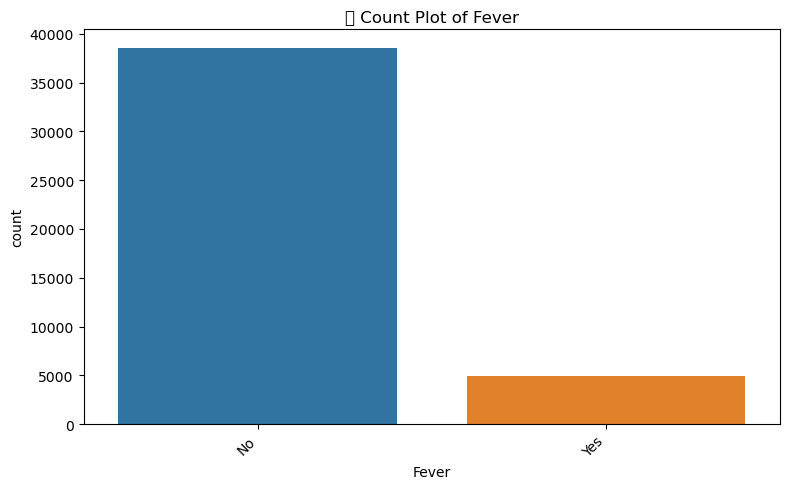

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3480\3149100879.py:12: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\ADMIN\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


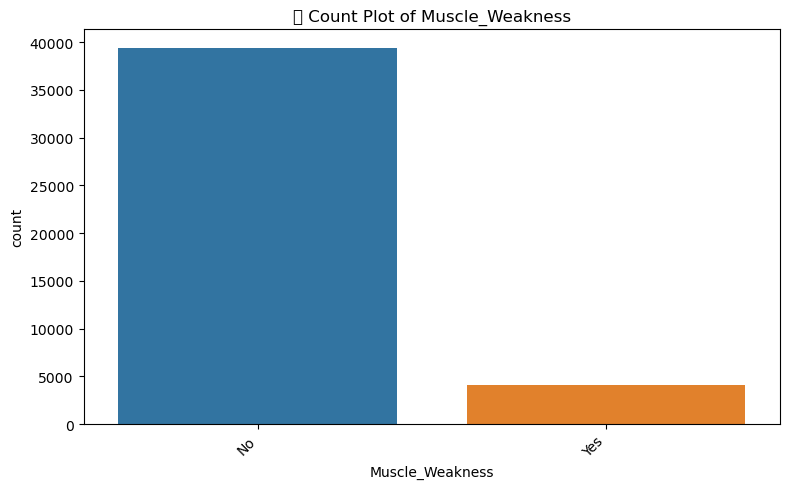

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3480\3149100879.py:12: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\ADMIN\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


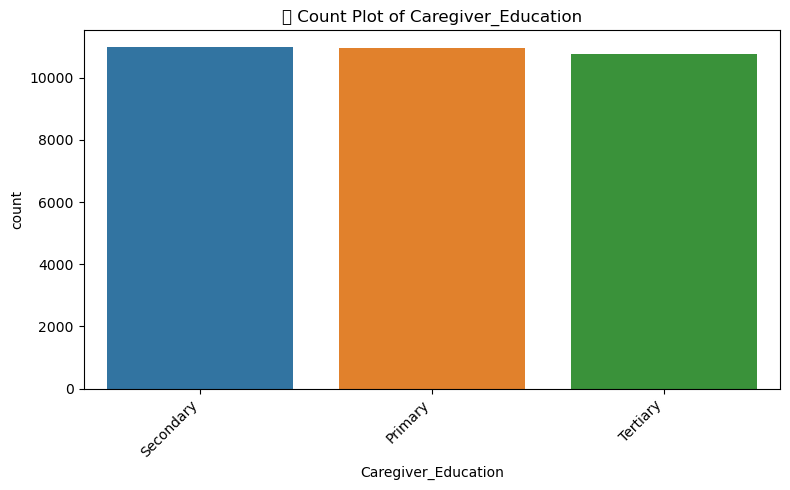

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3480\3149100879.py:12: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\ADMIN\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


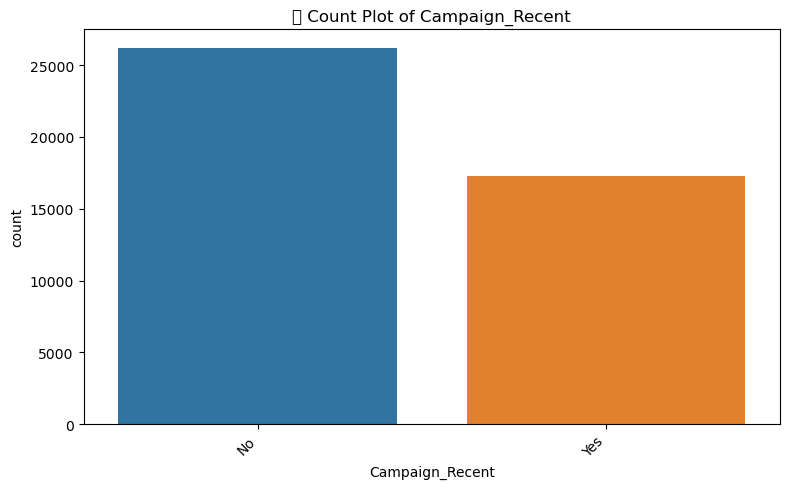

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3480\3149100879.py:12: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\ADMIN\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


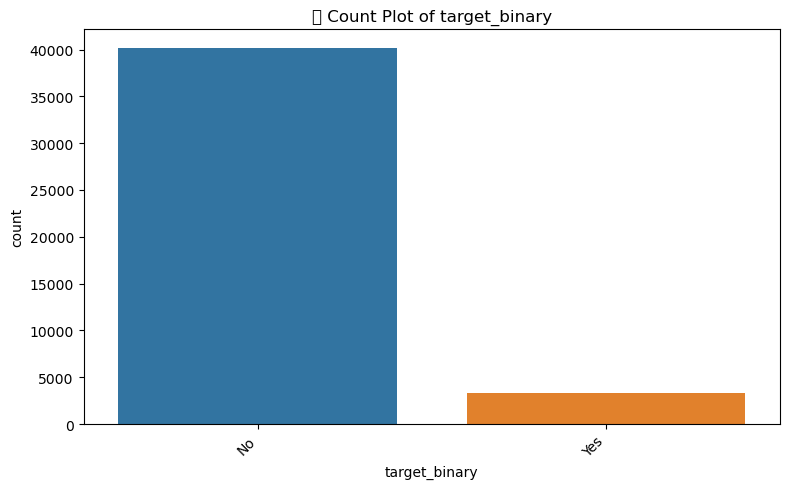

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

categorical_cols = df.select_dtypes(include='object').columns

for col in categorical_cols:
    num_categories = df[col].nunique()
    plt.figure(figsize=(max(8, num_categories * 0.5), 5))  # Dynamic width
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f'📊 Count Plot of {col}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


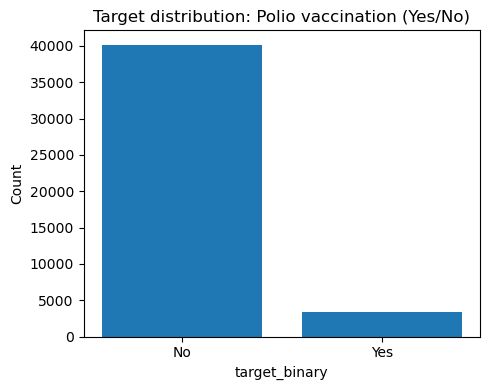

In [34]:
# (A) Target bar chart
plt.figure(figsize=(5,4))
counts = df["target_binary"].value_counts()
plt.bar(counts.index.astype(str), counts.values)
plt.title("Target distribution: Polio vaccination (Yes/No)")
plt.xlabel("target_binary")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


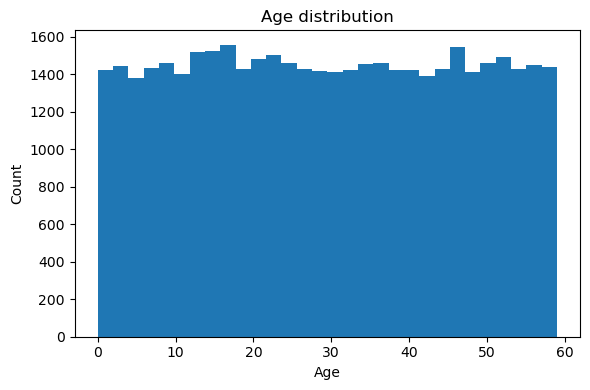

In [35]:
# (B) If there's an Age column, show its histogram by vaccination (optional)
age_col = None
for c in df.columns:
    if c.lower() == "age":
        age_col = c
        break

if age_col is not None and pd.api.types.is_numeric_dtype(df[age_col]):
    # plain histogram of Age
    plt.figure(figsize=(6,4))
    plt.hist(df[age_col].dropna().values, bins=30)
    plt.title("Age distribution")
    plt.xlabel("Age")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()



In [36]:
# 5) Features / preprocessing ------------------------------------------------
X = df.drop(columns=[target_col, "target_binary"])
y = df["target_binary"]

In [37]:
# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), numeric_cols),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_cols)
    ]
)


In [38]:
# 6) Train/test split --------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [39]:
# 7) Naive Bayes model (Bernoulli for one-hot features) ---------------------
model = Pipeline(steps=[
    ("prep", preprocess),
    ("nb", BernoulliNB())
])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [40]:
# 8) Evaluation --------------------------------------------------------------
print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred, target_names=["No","Yes"], zero_division=0))

cm = confusion_matrix(y_test, y_pred, labels=["No","Yes"])
print("\n=== CONFUSION MATRIX (rows=Actual, cols=Predicted) ===")
print(pd.DataFrame(cm, index=["Actual_No","Actual_Yes"], columns=["Pred_No","Pred_Yes"]))


=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

          No       0.92      1.00      0.96     10037
         Yes       0.29      0.00      0.01       838

    accuracy                           0.92     10875
   macro avg       0.60      0.50      0.48     10875
weighted avg       0.87      0.92      0.89     10875


=== CONFUSION MATRIX (rows=Actual, cols=Predicted) ===
            Pred_No  Pred_Yes
Actual_No     10027        10
Actual_Yes      834         4


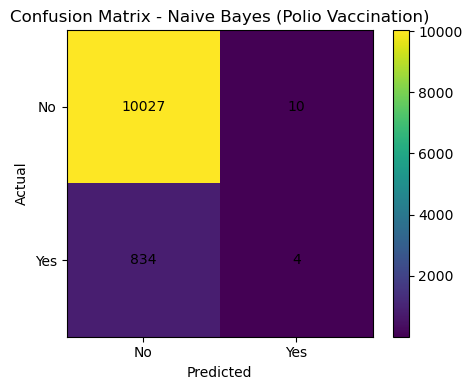

In [41]:
# Plot confusion matrix (pure matplotlib)
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix - Naive Bayes (Polio Vaccination)')
plt.colorbar()
ticks = np.arange(2)
plt.xticks(ticks, ["No","Yes"])
plt.yticks(ticks, ["No","Yes"])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

In [42]:


# Optional: ROC-AUC if classes are binary and we can get probabilities
try:
    y_prob = model.predict_proba(X_test)[:, 1]  # probability for "Yes"
    # Convert y_test to 0/1
    y_test_bin = (y_test.values == "Yes").astype(int)
    auc = roc_auc_score(y_test_bin, y_prob)
    print(f"\nROC-AUC: {auc:.3f}")
except Exception as e:
    print("\nROC-AUC not available:", e)


ROC-AUC: 0.655
